# Implementation of Linear Regression

**Author:** Diego Antonio García Padilla (A01710777)

---

For the submission of Module 2, I will implement a linear regression model using the [Boston House Price Dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data). The dataset contains the following features:

1) `CRIM`: per capita crime rate by town.
2) `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
3) `INDUS`: proportion of non-retail business acres per town.
4) `CHAS`: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
5) `NOX`: nitric oxides concentration (parts per 10 million) [parts/10M].
6) `RM`: average number of rooms per dwelling.
7) `AGE`: proportion of owner-occupied units built prior to 1940.
8) `DIS`: weighted distances to five Boston employment centres.
9) `RAD`: index of accessibility to radial highways.
10) `TAX`: full-value property-tax rate per \$10,000 [$/10k].
11) `PTRATIO`: pupil-teacher ratio by town.
12) `B`: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
13) `LSTAT`: % lower status of the population.

And the following output feature:

14) **MEDV**: Median value of owner-occupied homes in \$1000's [k$].

## Enviroment setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy import stats
from typing import Tuple

In [2]:
np.random.seed(42)

## ETL Process

### Extract

In [3]:
# Load data
df = pd.read_csv("boston.csv")

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Transform

First, I will check the data types of the features to ensure they are appropriate for the analysis.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


Everything seems to be in order with the data types, except for CHAS, which is currently of type `int64`. Since this is a categorical variable and I want to do a linear regression analysis, I will remove it from the dataset.


In [5]:
df.drop(columns=["CHAS"], inplace=True)

Then, I will drop missing values from the dataset to ensure a complete case analysis.

In [6]:
# Drop missing values if any
df = df.dropna()

#### Correlation and $p_{values}$

To know which features are most important for predicting the target variable, I can calculate its correlation and p-values, and then visualize the correlations using a heatmap.

If the correlation is high (close to 1 or -1), it indicates a strong relationship between the feature and the target variable. If the correlation is low (close to 0), it suggests a weak relationship. 

The p-value helps to determine the statistical significance of the correlation. A low p-value (typically < 0.05) indicates that the correlation is statistically significant, while a high p-value suggests that the correlation may be due to chance.


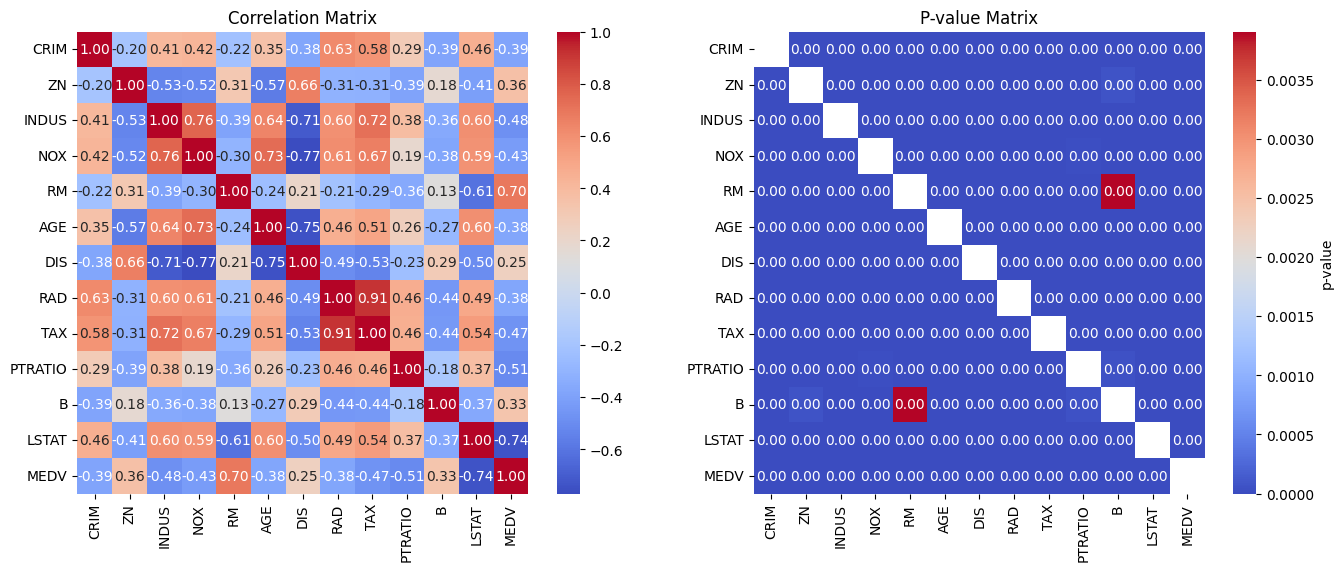

In [7]:
def p_value_matrix(df):
    p_values = pd.DataFrame(columns=df.columns, index=df.columns)
    for col in df.columns:
        for target in df.columns:
            if col != target:
                _, p_value = stats.pearsonr(df[col], df[target])
                p_values.loc[col, target] = p_value
    return p_values

def plot_correlation_and_p_values(df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Correlation Matrix")

    sns.heatmap(p_value_matrix(df).astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-value'}, ax=axes[1])
    axes[1].set_title("P-value Matrix")

plot_correlation_and_p_values(df)

With p-values that small, I will use correlation coefficients to identify the most important features for predicting the target variable.

If the absolute value of the correlation coefficient is greater than 0.4, I will consider the feature important for prediction.


In [8]:
# Drop irrelevant features
df.drop(columns=["CRIM", "ZN", "AGE", "DIS","RAD", "B"], inplace=True)

df.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,MEDV
0,2.31,0.538,6.575,296.0,15.3,4.98,24.0
1,7.07,0.469,6.421,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,222.0,18.7,5.33,36.2


I still have to check if there is any collinearity between the features. I can do this by looking at the correlation matrix and identifying any pairs of features with a high correlation coefficient (e.g., above 0.8 or below -0.8).


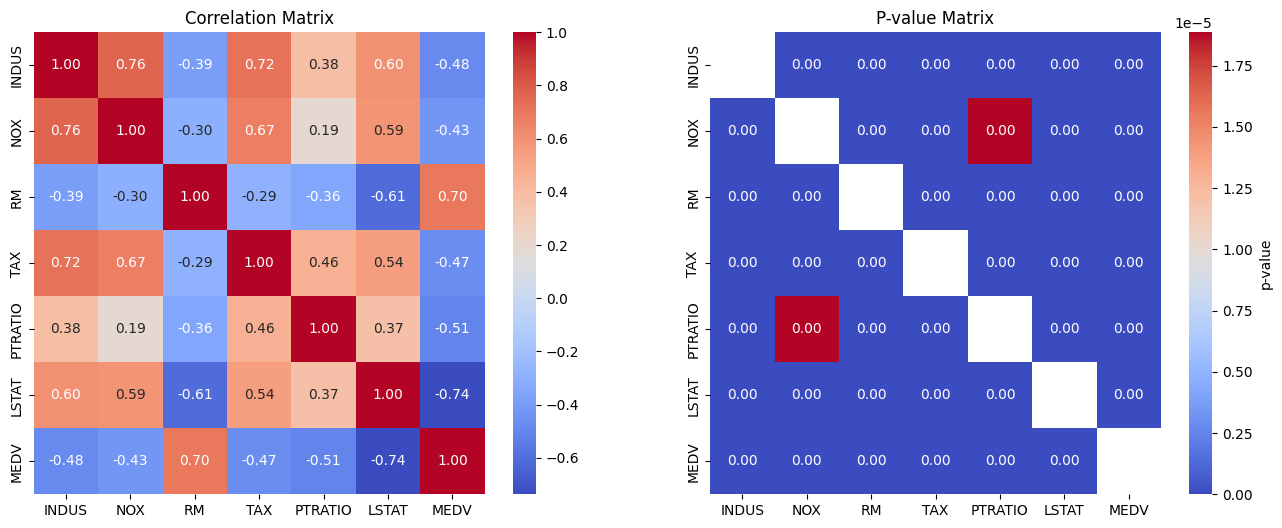

In [9]:
plot_correlation_and_p_values(df)

I'll drop INDUS and TAX because it has a very strong correlation with NOX.


In [10]:
df.drop(columns=["INDUS", "TAX"], inplace=True)

#### Data splitting


Now, I will standardize the features to ensure they are on the same scale. This is important for linear regression, as it can be sensitive to the scale of the input features.

But first, to avoid data leakage, we need to split the data into training and testing sets before applying any transformations.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#### Outlier removal

Now we can visualize the distribution of the target variable in the training set.

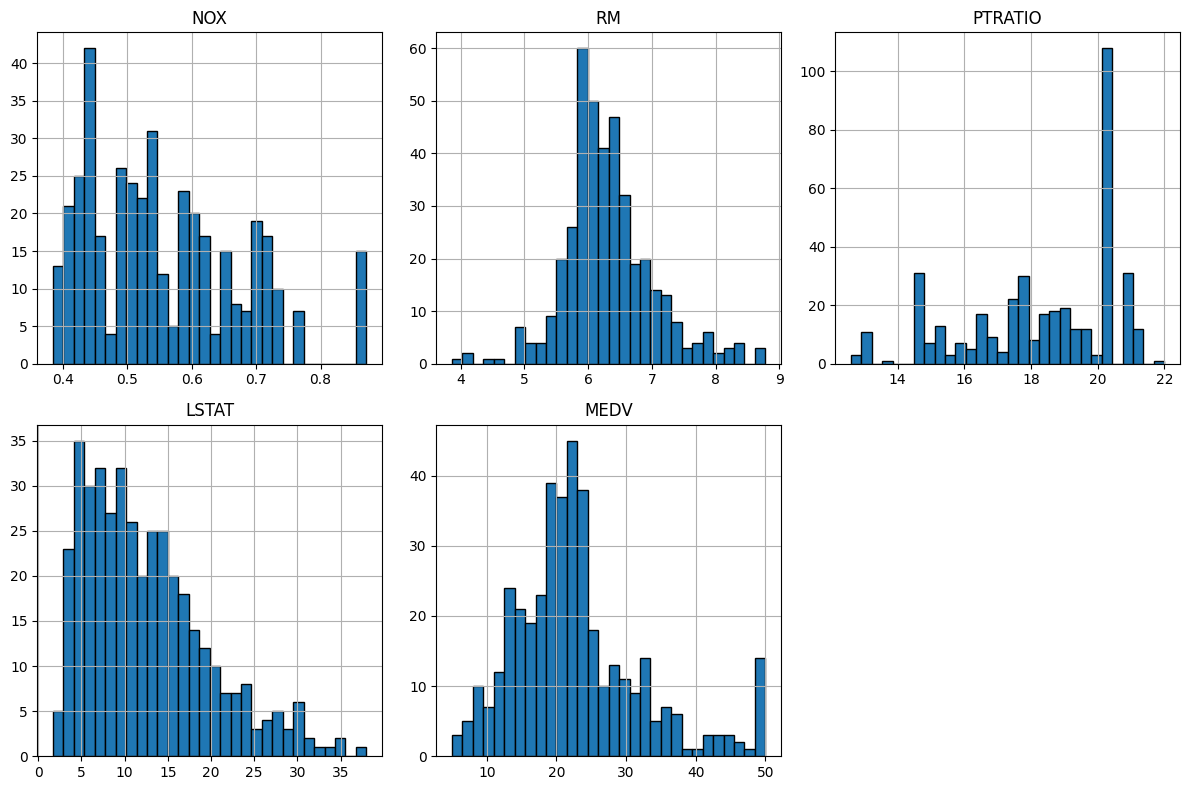

In [12]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

As we can see, there are a lot of outliers in the training set. 

- LSTAT is skewed to the right, with a long tail. I will use log transformation.
- NOX is also skewed. I will use winsorization to cap the values at the 5th and 95th percentiles.

In [13]:
# Log-transformation of LSTAT
print(f"Bias LSTAT before: {stats.skew(df_train['LSTAT']):.2f}")

df_train['LSTAT'] = np.log1p(df_train['LSTAT'])
df_test['LSTAT'] = np.log1p(df_test['LSTAT'])

print(f"Bias LSTAT after: {stats.skew(df_train['LSTAT']):.2f}")

Bias LSTAT before: 0.93
Bias LSTAT after: -0.15


In [14]:
# Winsorize NOX
print(f"Bias NOX before: {stats.skew(df_train['NOX']):.2f}")

lower_bound = df_train["NOX"].quantile(0.05)
upper_bound = df_train["NOX"].quantile(0.95)

df_train["NOX"] = df_train["NOX"].clip(lower=lower_bound, upper=upper_bound)
df_test["NOX"] = df_test["NOX"].clip(lower=lower_bound, upper=upper_bound)

print(f"Bias NOX after: {stats.skew(df_train['NOX']):.2f}")

Bias NOX before: 0.75
Bias NOX after: 0.45


In [15]:
# Reset index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Extract X and y
X_train = df_train.drop('MEDV', axis=1)
y_train = df_train['MEDV']
X_test = df_test.drop('MEDV', axis=1)
y_test = df_test['MEDV']

# Rebuild dataframes
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

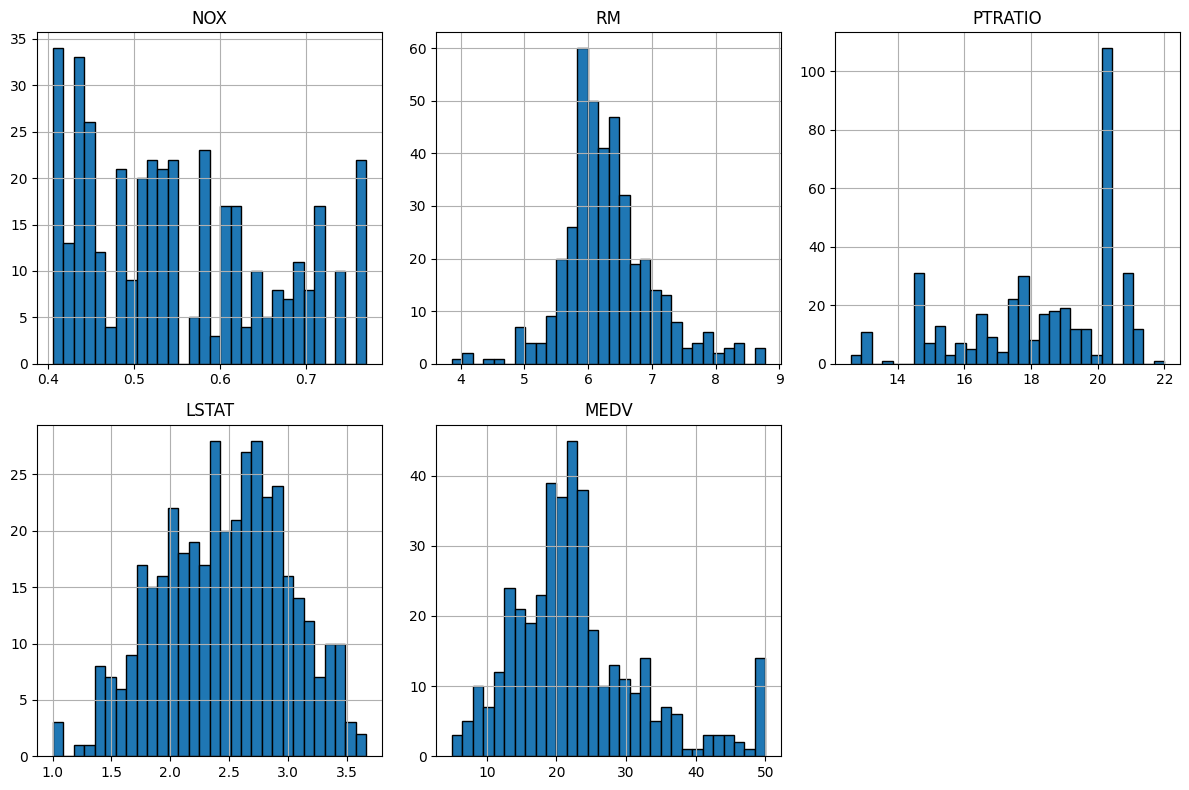

In [16]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

#### Standarization (z-score)

In [17]:
scaler_X = StandardScaler()

X_train = pd.DataFrame(scaler_X.fit_transform(X_train))
X_test = pd.DataFrame(scaler_X.transform(X_test))

df_train = pd.concat([X_train, y_train], axis=1)
df_train.columns = df.columns
df_test = pd.concat([X_test, y_test], axis=1)
df_test.columns = df.columns

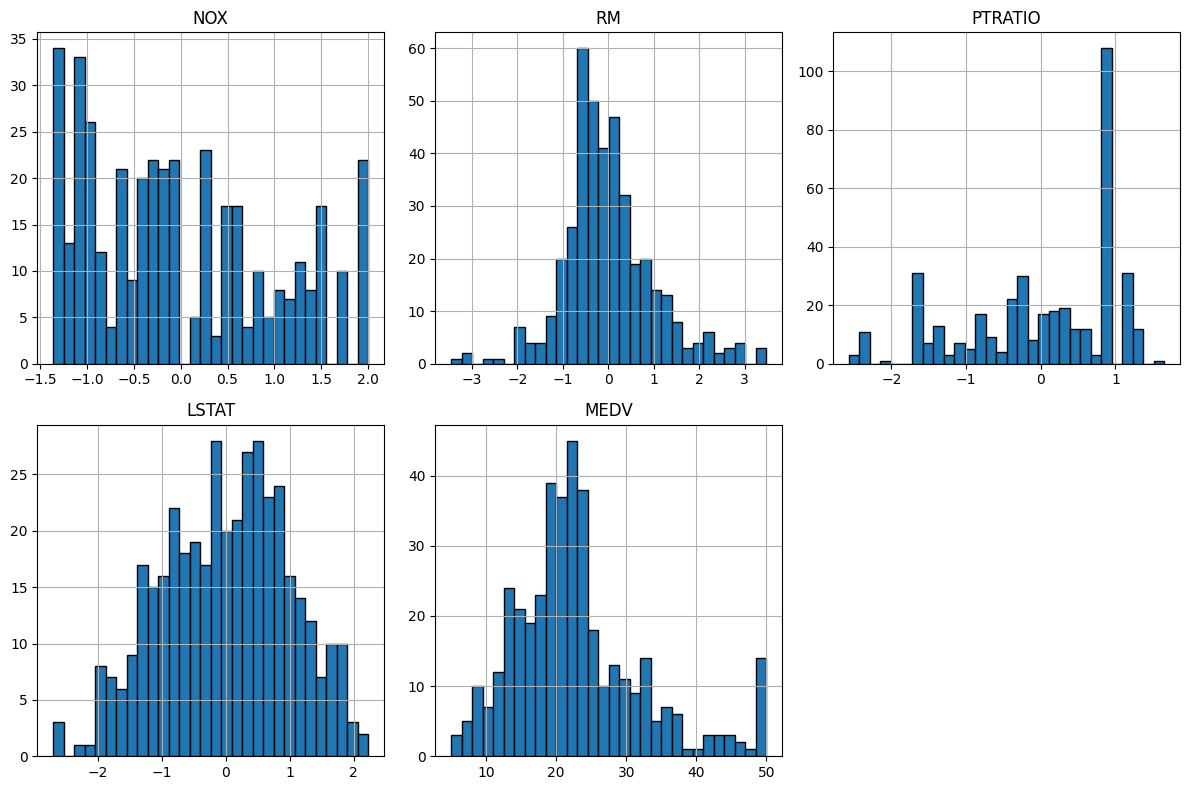

In [18]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

## Linear Regression

### Linear regression functions

In [19]:
def h(x: np.ndarray, theta: np.ndarray, b: float) -> float:
    """
    Hypothesis function for linear regression.

    Predicts the median housing price in $1000s.

    Parameters:

    - x: Vector of feature values
    - theta: Vector of model parameters
    - b: Bias term

    Returns:
    - Predicted median housing price in $1000s
    """
    return np.dot(x, theta) + b

def standard_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the standard error of the predictions.

    Parameters:
    - y_true: Vector of true median housing prices in $1000s
    - y_pred: Vector of predicted median housing prices in $1000s

    Returns:
    - Standard error of the predictions
    """
    return np.mean((y_true - y_pred) ** 2)

def gradient_descent(X: np.ndarray, y: np.ndarray, theta: np.ndarray, b: float, learning_rate: float, epochs: int) -> Tuple[np.ndarray, float, list]:
    """
    Perform gradient descent to optimize the model parameters.

    Parameters:
    - X: Feature matrix
    - y: True median housing prices in $1000s
    - theta: Initial model parameters
    - b: Initial bias term
    - learning_rate: Learning rate for gradient descent
    - epochs: Number of iterations to run gradient descent

    Returns:
    - (theta, b, error): Tuple of optimized model parameters, bias term, and error history
    """
    m = len(y)
    error_history = []
    for _ in range(epochs):
        y_pred = h(X, theta, b)
        error = y_pred - y
        error_history.append(standard_error(y, y_pred))
        theta -= (learning_rate / m) * np.dot(X.T, error)
        b -= (learning_rate / m) * np.sum(error)
    return theta, b, error_history

### Model training

In [20]:
hypothesis_theta = np.random.randn(X_train.shape[1])
hypothesis_bias = np.random.randn()
learning_rate = 0.01
EPOCHS = 10000

theta, bias, error_history = gradient_descent(X_train.values, y_train.values, hypothesis_theta, hypothesis_bias, learning_rate, EPOCHS)

print("Optimized parameters (theta):", theta)
print("Optimized bias (b):", bias)
print("Last training error (MSE):", error_history[-1])

Optimized parameters (theta): [ 0.38465601  2.55879081 -1.64069501 -5.41864095]
Optimized bias (b): 22.796534653465173
Last training error (MSE): 23.04927388830634


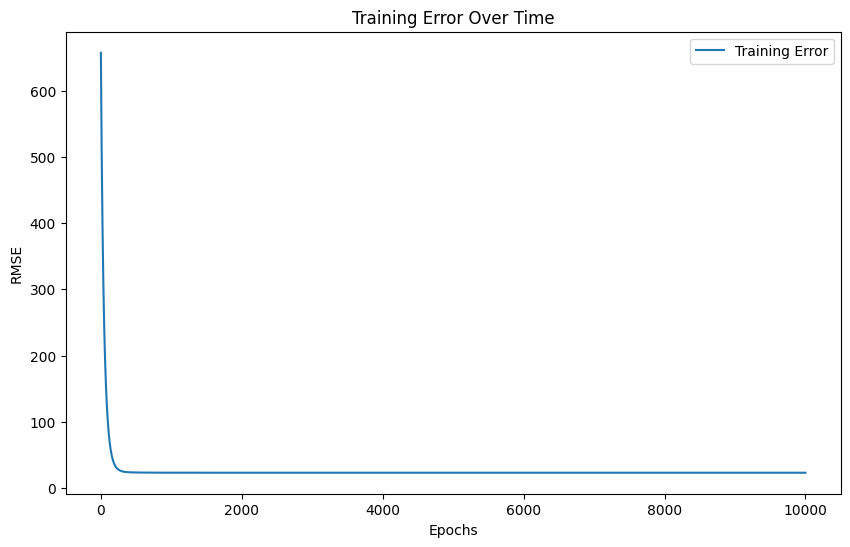

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), error_history, label="Training Error")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training Error Over Time")
plt.legend()
plt.show()

### Model testing

#### Prueba con test

In [22]:
y_train_pred = h(X_train.values, theta, bias)
y_test_pred = h(X_test.values, theta, bias)
test_error = standard_error(y_test.values, y_test_pred)

print(f'Test Error: {test_error}')

Test Error: 22.066590769210425


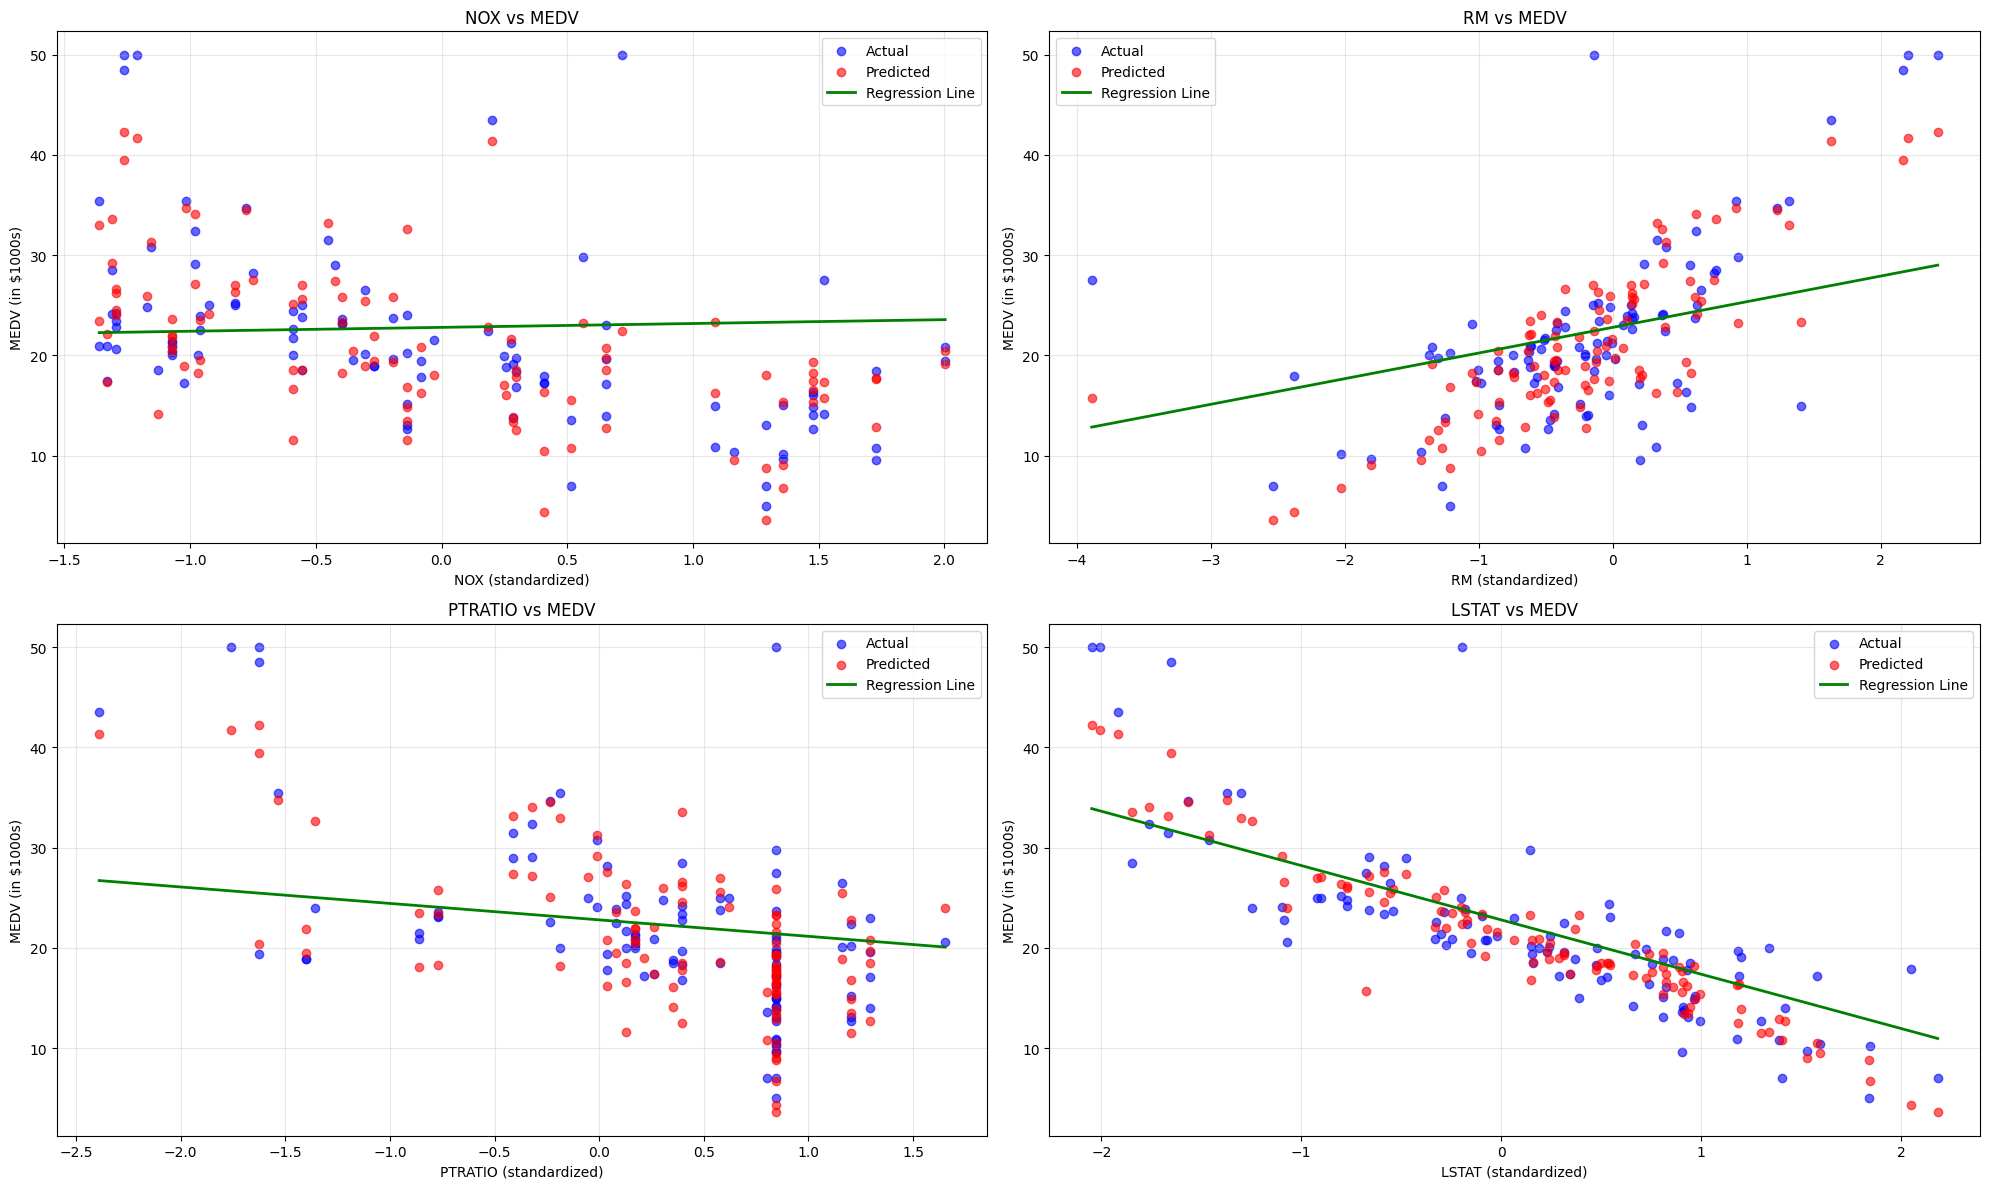

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

feature_names = ['NOX', 'RM', 'PTRATIO', 'LSTAT']

for i, feature_name in enumerate(feature_names):
    # Position
    row = i // 2
    col = i % 2

    # Scatter plot of actual values
    axes[row, col].scatter(X_test.iloc[:, i], y_test, alpha=0.6, color='blue', label='Actual')

    # Scatter plot of predicted values
    axes[row, col].scatter(X_test.iloc[:, i], y_test_pred, alpha=0.6, color='red', label='Predicted')

    # Regression line
    x_range = np.linspace(X_test.iloc[:, i].min(), X_test.iloc[:, i].max(), 100)
    y_line = theta[i] * x_range + bias
    axes[row, col].plot(x_range, y_line, color='green', linewidth=2, label='Regression Line')

    axes[row, col].set_xlabel(f'{feature_name} (standardized)')
    axes[row, col].set_ylabel('MEDV (in $1000s)')
    axes[row, col].set_title(f'{feature_name} vs MEDV')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Diagnóstico de overfitting

In [24]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R² Train: {r2_train}')
print(f'R² Test: {r2_test}')
print(f'R² Train - R² Test: {r2_train - r2_test}')


R² Train: 0.7346797423452396
R² Test: 0.6990937898162399
R² Train - R² Test: 0.035585952528999654
